In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kd_utils import MyDtree
from IPython.display import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/data')

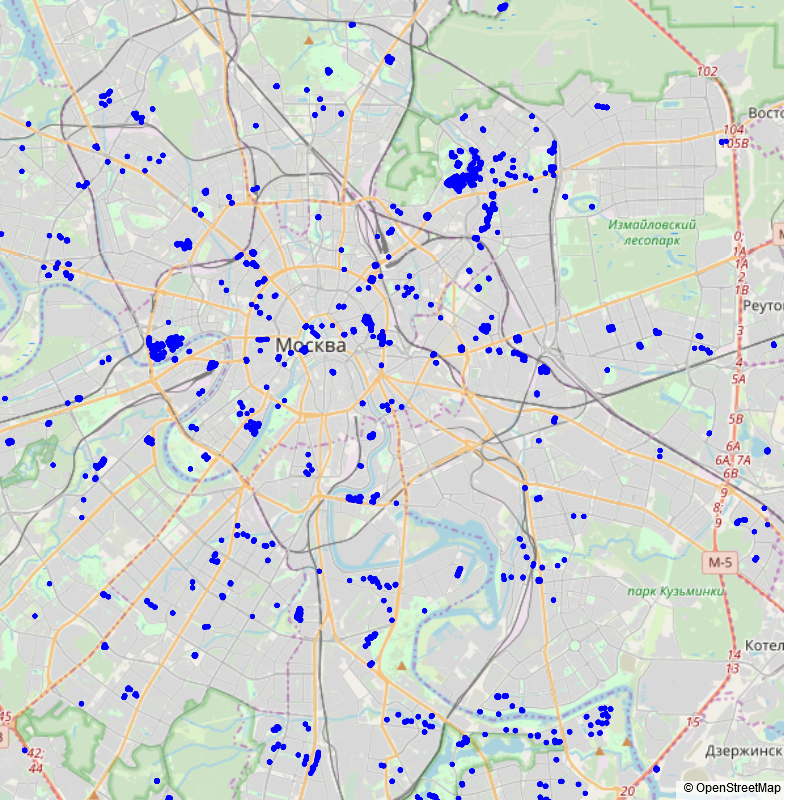

In [0]:
Image(filename='msc_points_init.png', width=500)

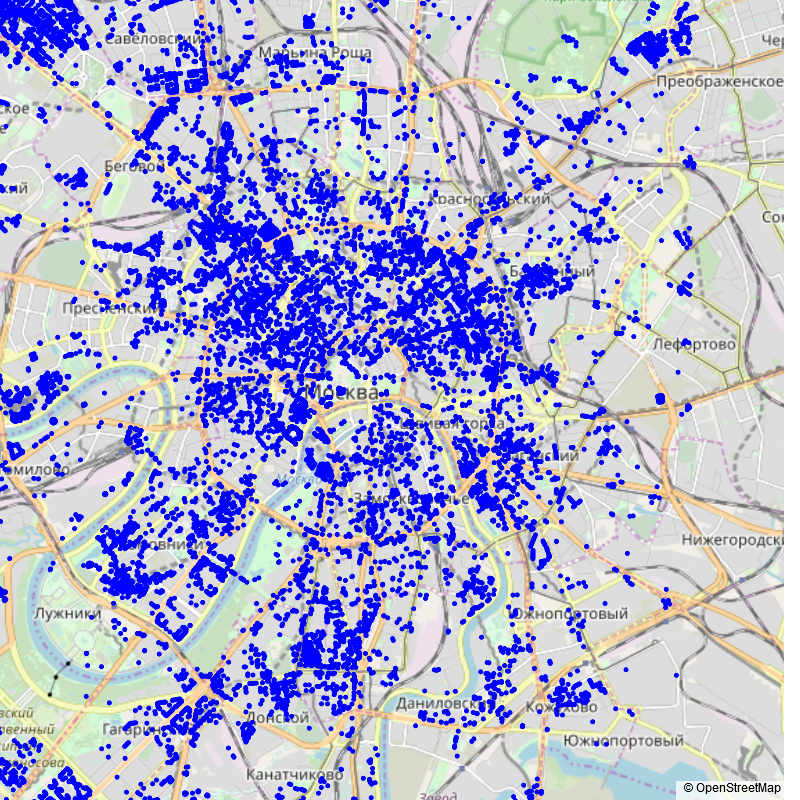

In [0]:
Image(filename='msc_points.png', width=500)

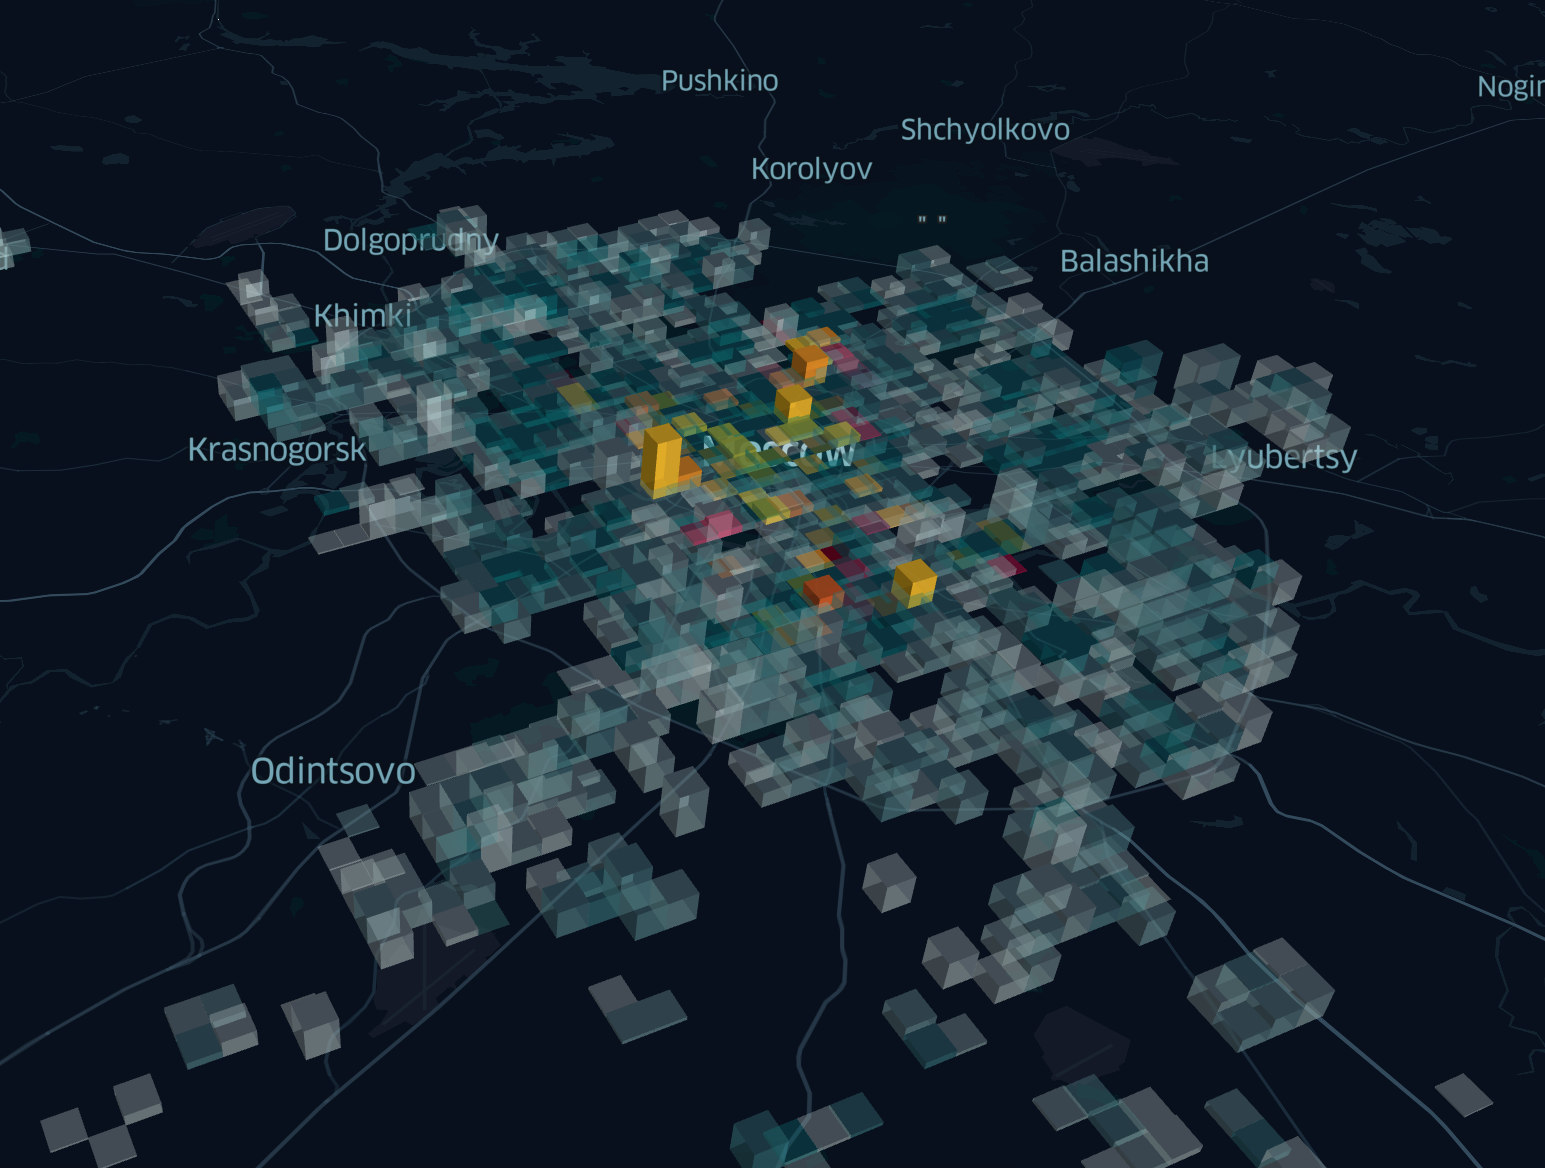

In [0]:
Image(filename='msc_box.png', width=500)

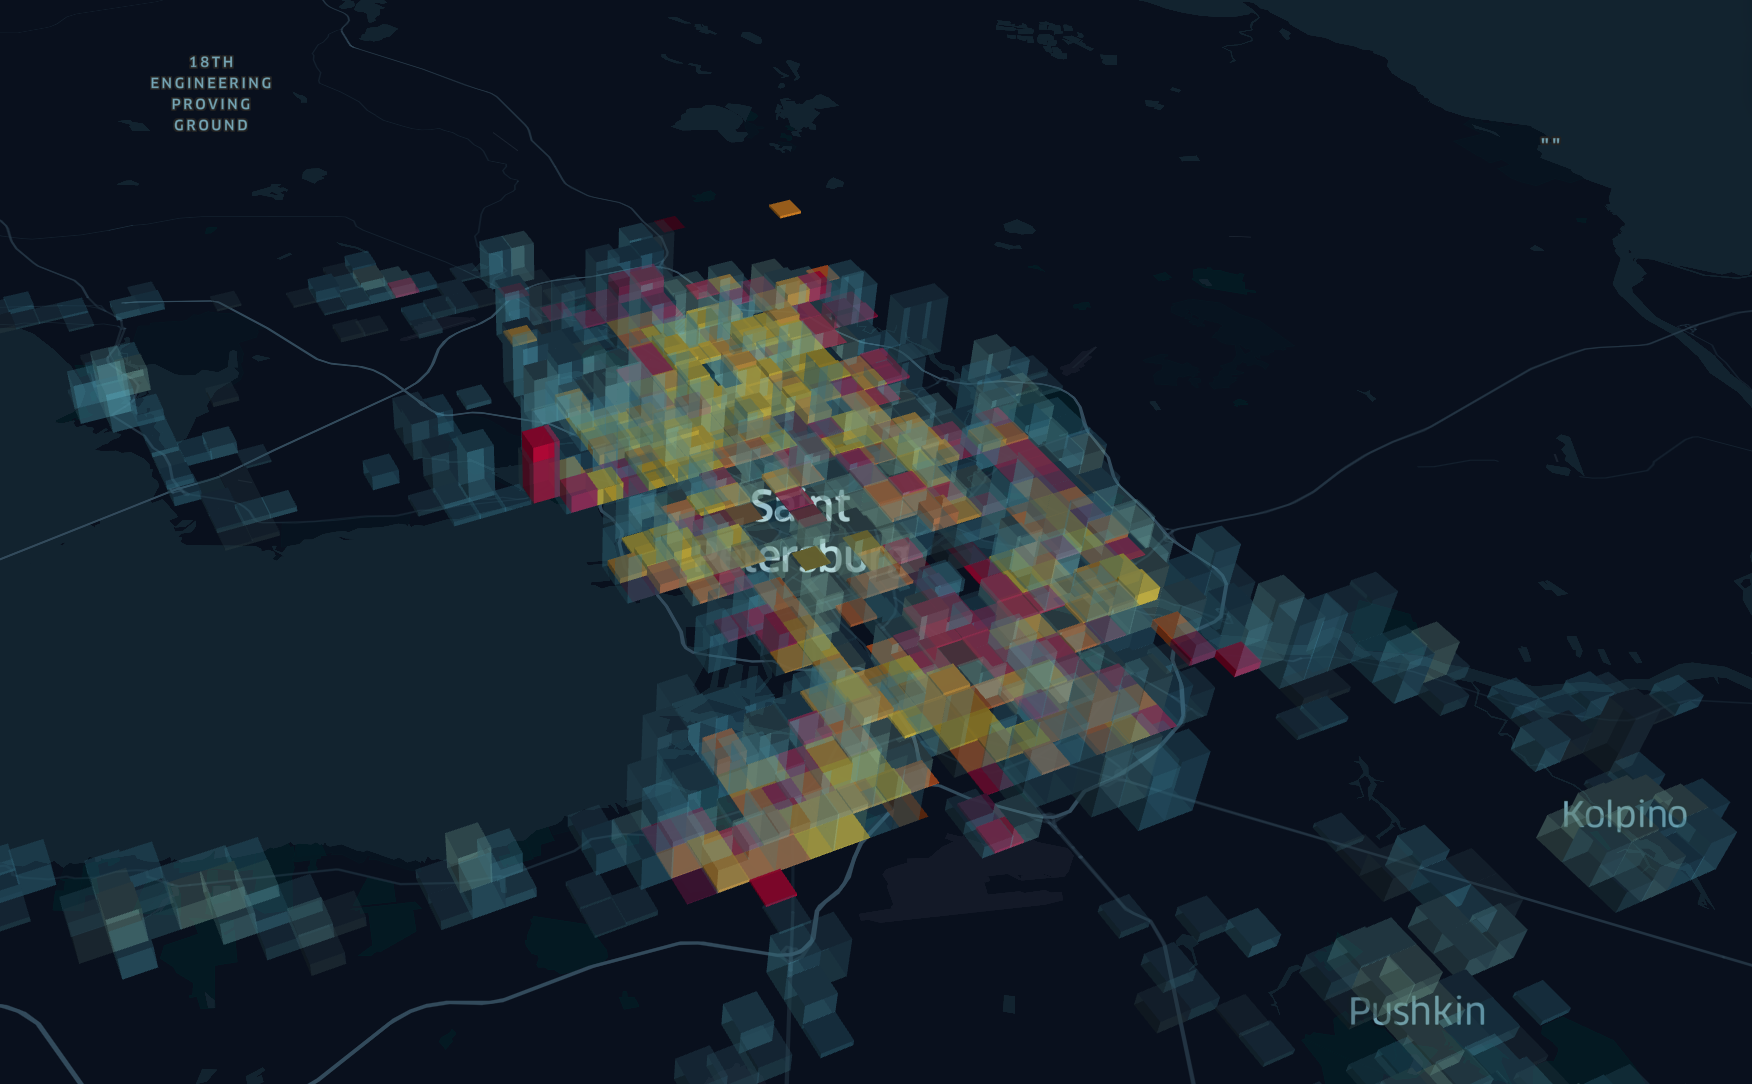

In [0]:
Image(filename='spb_box.png', width=500)

In [0]:
city = 'msc'

def load_osm_df(ifile_path):
  df_osm = pd.read_csv(ifile_path)
  df_osm.rename(columns={
      'addr:city': 'city_osm',
      'addr:street': 'street_osm',
      'addr:housenumber': 'house_osm',
      'building:levels': 'floors_osm',
      'height': 'height_osm',
      'Unnamed: 0': 'ind'
      }, inplace=True)
  return df_osm
  
df_osm = load_osm_df(f'{city}_height_map_all_102019.csv')

In [0]:
def load_zkh_df(ifile_path):
  df_zkh = pd.read_csv(ifile_path)
  df_zkh = df_zkh.dropna(subset=['lat', 'lon'])
  df_zkh.rename(columns={
      'formalname_city': 'city_zkh',
      'formalname_street': 'street_zkh',
      'house_number': 'house_zkh',
      'floor_count_max': 'floors_zkh',
      }, inplace=True)
  df_zkh['ind_zkh'] = range(len(df_zkh))
  return df_zkh
  
df_zkh = load_zkh_df(f'reestrmkd.{city}.latlon.gl.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



In [0]:
def convert_num(x):
  try:
      return float(x)
  except:
    return np.NaN

df_osm['house_osm'] = df_osm['house_osm'].apply(convert_num)
df_zkh['house_zkh'] = df_zkh['house_zkh'].apply(convert_num)

In [0]:
lats, lons = df_zkh['lat'].values, df_zkh['lon'].values
my_dtree = MyDtree(lats, lons)
dist, ix = my_dtree.get_knearest(54, 53, 1)
print('nearest', lats[ix], lons[ix])

nearest 60.173812 29.453863000000002


In [0]:
house_numbers_zkh = df_zkh['house_zkh'].values

def get_nearest_zkh(x):
  dist, ix = my_dtree.get_knearest(x['lat'], x['lon'], 10)
  need_ix = [i for i in ix if house_numbers_zkh[i] == x['house_osm']]
  if len(need_ix) > 0:
    return need_ix[0]
  else:
    return ix[0]

df_osm['ind_zkh'] = df_osm.apply(get_nearest_zkh, axis=1)
df_total = pd.merge(df_osm, df_zkh, on='ind_zkh', how='inner')
print(len(df_total))
print('found proper:', df_total.query('house_zkh == house_osm').__len__())

19768
found proper: 76


In [0]:
# need_cols = ['house_osm', 'street_osm', 'floors_osm', 
#              'height_osm', 'street_zkh', 'house_zkh',
#              'floors_zkh', 'built_year']
# df_total = df_total[need_cols]

In [0]:
# правильно сопоставленные здания (номер дома совпадает)
print('df_total house proper found:', df_total.query('house_zkh == house_osm').__len__())
df_total.dropna(subset=['floors_osm']).query('house_zkh == house_osm').corr()['floors_osm']['floors_zkh']
# msc df_total house proper found: 232
# corr 0.7207031640176726
# spb df_total house proper found: 11367

#     corr zkh/os         proper
# msc 0.7207031640176726  232
# spb 0.6424389099489376  11367

df_total house proper found: 11367


0.6424389099489376

In [0]:
df_total.corr()['floors_osm']

ind                          -0.020728
id_x                          0.161191
lat_x                         0.066285
lon_x                        -0.155800
house_osm                    -0.084163
floors_osm                    1.000000
ind_zkh                      -0.044529
house_zkh                    -0.036957
management_organization_id    0.147064
built_year                    0.296224
exploitation_start_year       0.313692
floors_zkh                    0.477439
floor_count_min               0.361902
entrance_count               -0.122636
elevators_count               0.065835
quarters_count                0.145059
living_quarters_count         0.175163
unliving_quarters_count       0.122963
playground                   -0.113546
sportsground                 -0.032187
chute_count                   0.144502
electrical_entries_count      0.022900
lat_y                         0.068094
lon_y                        -0.156073
Name: floors_osm, dtype: float64

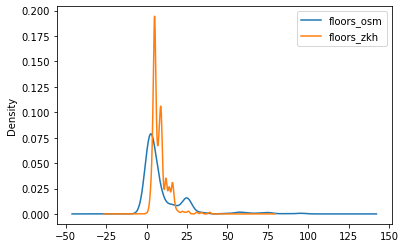

In [0]:
df_total[['floors_osm', 'floors_zkh']].plot(kind='kde');
# msc

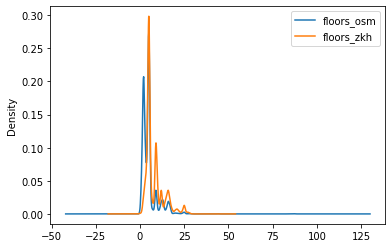

In [0]:
df_total[['floors_osm', 'floors_zkh']].plot(kind='kde');
# spb

In [0]:
df_total[['floors_osm', 'built_year', 'height_osm']].dropna(subset=['height_osm'])

floors_osm  built_year height_osm
0             3.0      2017.0          6
1             1.0      2017.0          4
2             1.0      2017.0          4
3             1.0      2017.0          4
4             1.0      2017.0          4
...           ...         ...        ...
83629         2.0      2017.0        5.6
83630         2.0      2017.0        5.6
83631         2.0      2017.0        5.6
83632         2.0      2017.0        5.6
83633         2.0      2017.0        5.6

[35142 rows x 3 columns]

In [0]:
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def get_score(y_true, y_pred):
  return dict(
    corr=np.corrcoef(y_true, y_pred)[0][1],
    rmse=mean_squared_error(y_true, y_pred)**0.5,
    r2=r2_score(y_true, y_pred),
  )

reg = LinearRegression()
df_total['height_osm'] = df_total['height_osm'].apply(convert_num)
df_total = df_total[['floors_osm', 'built_year', 'height_osm']].dropna()

y = df_total.pop('height_osm')
numeric_features = df_total.corr().columns.tolist()
X = df_total
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
score = get_score(y_test, y_pred)
pd.DataFrame([score])

corr      rmse        r2
0  0.98216  2.411574  0.964606

In [0]:
cols = ['city',    'corr',      'rmse',     'r2',         'proper',  'corr zkh/osm floors']
pd.DataFrame(
    [['msc',     0.97125,	  14.45834,	0.943015,   232,     0.7207031640176726],
     ['spb',     0.981142,	2.524339,	0.962602,   11367,   0.6424389099489376]],
    columns=cols)

city      corr       rmse        r2  proper  corr zkh/osm floors
0  msc  0.971250  14.458340  0.943015     232             0.720703
1  spb  0.981142   2.524339  0.962602   11367             0.642439

In [0]:
# msc +20K buildings
# spb +26K buildings

In [0]:
X_train.shape, X_test.shape

((20168, 2), (6723, 2))

In [ ]:
df_total['built_year'].hist()